In [2]:
import pandas as pd
import numpy as np
from data_processor import *
from lda_model import LDATopicModel
from classifier import TopicClassifier
from visualizer import *
from brain_visualizer import *

data_path = 'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data'

inp_df = pd.read_csv(os.path.join(data_path,'train_data/260128_wsev_smc_combined_cn_included.csv'))
inp_df = inp_df[inp_df['DX']!='HC'] # EXCLUDE WSEV HC

print(inp_df['DX'].value_counts())

# df_nacc_resilience = pd.read_csv(data_path + '/nacc/NACC_resilience_inference.csv')
# df_adni4_resilience = pd.read_csv(data_path + '/adni/ADNI4_resilience_inference.csv')
# # df_nacc_resilience = pd.read_csv('C:/Users/BREIN/Desktop/stage_copath/20260122_NACC_linear_group.csv')

# df_adni4_resilience = df_adni4_resilience.rename(columns={"FULL_ID": "SUBJ_ID"})
# df_nacc_resilience = df_nacc_resilience.rename(columns={"subject_id" : "SUBJ_ID"})
# nacc_raw = pd.read_csv(data_path + '/nacc/260120_NACC_VA_TAU_PATH_matched.csv')

DX
NC        166
AD         72
svPPA      59
bvFTD      53
nfvPPA     46
DLB        25
PD         24
SVAD       24
Name: count, dtype: int64


In [3]:
from scipy.stats import pearsonr  # or spearmanr if you prefer
def resilient_subgroup_visualization(inp_df,prob_cols, group_col,group_order,cohort='NACC',scatter_col='standardized_residual'):
    group_means = (
        inp_df
        .groupby(group_col)[prob_cols]
        .mean()
        .reindex(group_order)
    )
###################### GROUP MEAN LEVEL #####################
    # ------------------------------------------------------------
    # Plot heatmap
    # ------------------------------------------------------------
    plt.figure(figsize=(8, 5))

    sns.heatmap(
        group_means,
        cmap="Reds",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "Mean predicted probability"}
    )

    plt.xlabel("Predicted pathology")
    plt.ylabel("Subgroup")
    plt.title(f"{cohort} Group-wise Mean Predicted Probability Distribution")
    plt.tight_layout()
    plt.show()
###################### SUBJECT LEVEL #####################
    # ------------------------------------------------------------
    # Sort: group first, then descending P(AD)
    # ------------------------------------------------------------
    inp_df[group_col] = pd.Categorical(
        inp_df[group_col],
        categories=group_order,
        ordered=True
    )

    df_sorted = (
        inp_df
        .sort_values([group_col, "P(AD)"], ascending=[True, False])
        .reset_index(drop=True)
    )


    heatmap_data = df_sorted[prob_cols]

    # ------------------------------------------------------------
    # Compute group positions for y-axis labels
    # ------------------------------------------------------------
    group_counts = (
        df_sorted[group_col]
        .value_counts()
        .reindex(group_order)
    )


    group_centers = {}
    start = 0

    for grp, count in group_counts.items():
        center = start + count / 2
        group_centers[grp] = center
        start += count

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        heatmap_data,
        cmap="Reds",
        vmin=0,
        vmax=1,
        yticklabels=False,
        cbar_kws={"label": "Predicted probability"}
    )

    # ------------------------------------------------------------
    # Horizontal lines between groups
    # ------------------------------------------------------------
    cum_sizes = np.cumsum(group_counts.values)

    for y in cum_sizes[:-1]:
        ax.hlines(y, *ax.get_xlim(), colors="black", linewidth=1.5)

    # ------------------------------------------------------------
    # TN subgroup labels on y-axis
    # ------------------------------------------------------------
    ax.set_yticks(list(group_centers.values()))
    ax.set_yticklabels(list(group_centers.keys()), rotation=0, fontsize=11)

    # ------------------------------------------------------------
    # Labels
    # ------------------------------------------------------------
    ax.set_xlabel("Predicted pathology")
    ax.set_ylabel("Subgroup")
    ax.set_title(f"{cohort} Subject-level Predicted Probability Heatmap\n(sorted by descending P(AD))")
    plt.tight_layout()
    plt.show()
    
###################### RADAR PLOT #####################
    topic_cols = [c for c in inp_df.columns if c.startswith("Topic_")]

    groups = inp_df[group_col].unique()
    n_groups = len(groups)
    n_topics = len(topic_cols)

    # ------------------------------------------------------------
    # Global max for shared axis
    # ------------------------------------------------------------
    global_max = (
        inp_df
        .groupby(group_col)[topic_cols]
        .mean()
        .values
        .max()
    )

    # ------------------------------------------------------------
    # Radar setup
    # ------------------------------------------------------------
    angles = np.linspace(0, 2 * np.pi, n_topics, endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])

    fig, axes = plt.subplots(
        1, n_groups,
        figsize=(4 * n_groups, 4),
        subplot_kw=dict(polar=True)
    )

    if n_groups == 1:
        axes = [axes]

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    # for ax, grp in zip(axes, groups):
    for ax, grp in zip(axes, group_order):
        print(ax,grp)

        grp_df = inp_df[inp_df[group_col] == grp]
        mean_topics = grp_df[topic_cols].mean().values
        mean_topics = np.concatenate([mean_topics, [mean_topics[0]]])

        ax.plot(angles, mean_topics, linewidth=2)
        ax.fill(angles, mean_topics, alpha=0.25)

        ax.set_title(grp, pad=20)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(topic_cols, fontsize=9)

        ax.set_ylim(0, global_max * 1.1)   # ✅ shared scale
        ax.set_yticklabels([])

    plt.suptitle(f"{cohort} Resilience Subgroup Topic Weight Profiles (shared radial scale)", fontsize=14)
    plt.tight_layout()
    plt.show()

###################### CORRELATION SCATTER #####################
    # -----------------------------
    # Example inputs
    # -----------------------------
    # inp_df: your dataframe
    # cols_to_corr: list of columns of probabilities to correlate
    # target_col: column to correlate against
    cols_to_corr = prob_cols
    target_col = scatter_col  # for example

    # -----------------------------
    # Plotting setup
    # -----------------------------
    n_cols = 3  # how many subplots per row
    n_rows = int(np.ceil(len(cols_to_corr) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()
    palette = sns.color_palette("tab10", n_colors=len(group_order))

    group_palette = dict(zip(group_order, palette))

    for ax, col in zip(axes, cols_to_corr):
        
        x = inp_df[col]
        y = inp_df[target_col]
        
        # Compute correlation
        r, p = pearsonr(x, y)
        
        # Scatter plot
        sns.scatterplot(
            x=x, y=y, hue=inp_df[group_col], palette=group_palette, ax=ax, s=60, alpha=0.8
        )
        
        # Fit line
        sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', ci=None)
        
        # Annotate r and p
        ax.text(0.05, 0.95, f"r={r:.2f}\np={p:.3f}",
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                fontsize = 13)
        
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        ax.set_title(f"{col} vs {target_col}")
        ax.set_xlim([0, 1])
        ax.set_ylim([-3, 4])

    # Remove empty axes if any
    for ax in axes[len(cols_to_corr):]:
        ax.remove()
    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper right', title=group_col, bbox_to_anchor=(1.05, 1))
    plt.suptitle('NACC')
    plt.tight_layout()
    plt.show()

In [5]:
region_cols = inp_df.loc[:, 'VA/2':'VA/2035'].columns
# nacc_filtered = nacc_raw[nacc_raw['DX'] != 'Unknown']
# nacc_cn = nacc_filtered[nacc_filtered['DX'] == 'CN']


## DOWNSAMPLE LARGE DX 
N = 25
dx_col = "DX"
balanced_parts = []

for dx, g in inp_df.groupby(dx_col):
    if dx == 'AD':
        N=100 ##
    elif dx == 'NC':
        N=100 ##
    else: 
        N=25
    if len(g) > N:
        g = g.sample(n=N, replace=False, random_state=42)
    balanced_parts.append(g)

train_df = pd.concat(balanced_parts).reset_index(drop=True)


#### add mci to AD ####
# train_df['DX'] = train_df['DX'].replace({'MCI' : 'AD'})

#### collapse all non-ad to one DX ##
train_df['DX_new'] = np.where(train_df['DX'].isin(['AD', 'NC']), train_df['DX'], 'non-AD')
print(train_df['DX_new'].value_counts())


DX_new
non-AD    148
NC        100
AD         72
Name: count, dtype: int64


In [6]:
k_list = range(4,26,2)
perplexities = []
cv_acc = []
dx_label = 'DX_new'
for k in [8]:
    print('K-topics = ', k)
    labels = train_df[dx_label].values
    ids = train_df["SUBJ_ID"].values

    lda = LDATopicModel(n_topics=k, alpha=1/k, beta=1/k)
    # lda = LDATopicModel(n_topics=k)
    print(lda.alpha, lda.beta)
    theta = lda.fit_transform(train_df[region_cols])
    classifier = TopicClassifier(n_splits=5)
    cv_results = classifier.cross_validate(theta, labels, ids, verbose=False)
    classifier.fit(theta, labels)
    print(f"k_topics {k}, CV ACC: {cv_results['accuracy']}")
    print(lda._theta.shape)
    
    perplexities.append(lda._perplexity)
    cv_acc.append(cv_results['accuracy'])

K-topics =  8
0.125 0.125


c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


k_topics 8, CV ACC: 0.725
(320, 8)


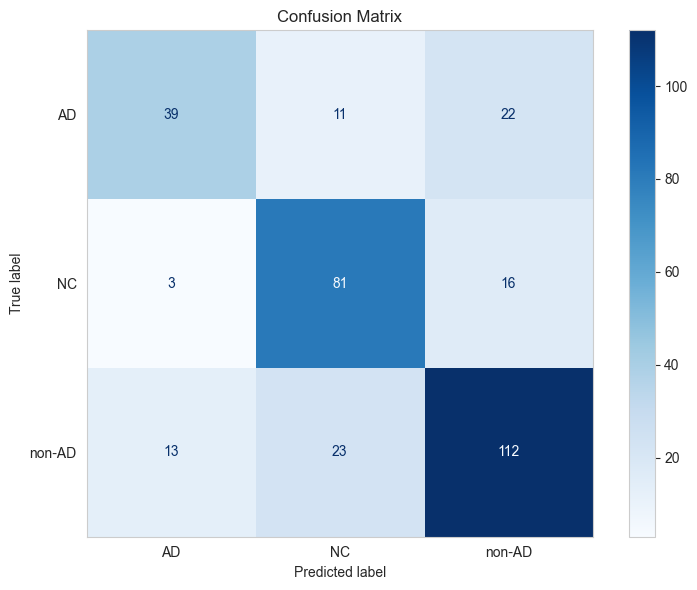

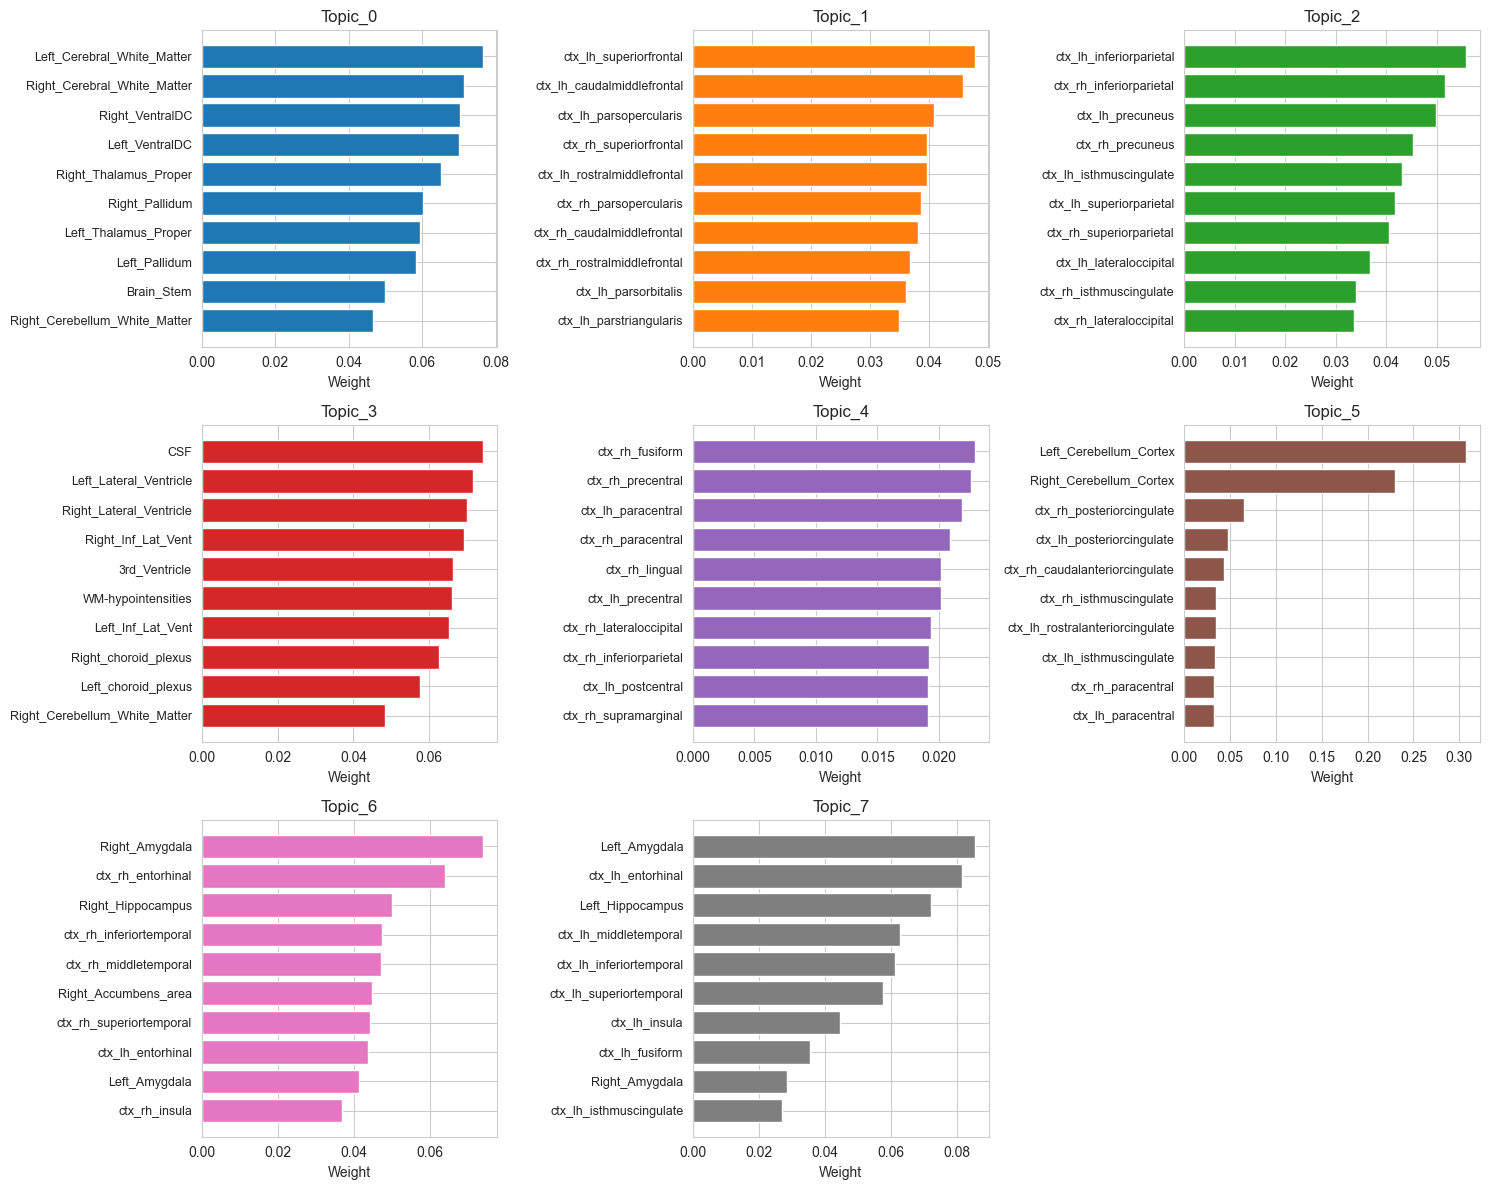

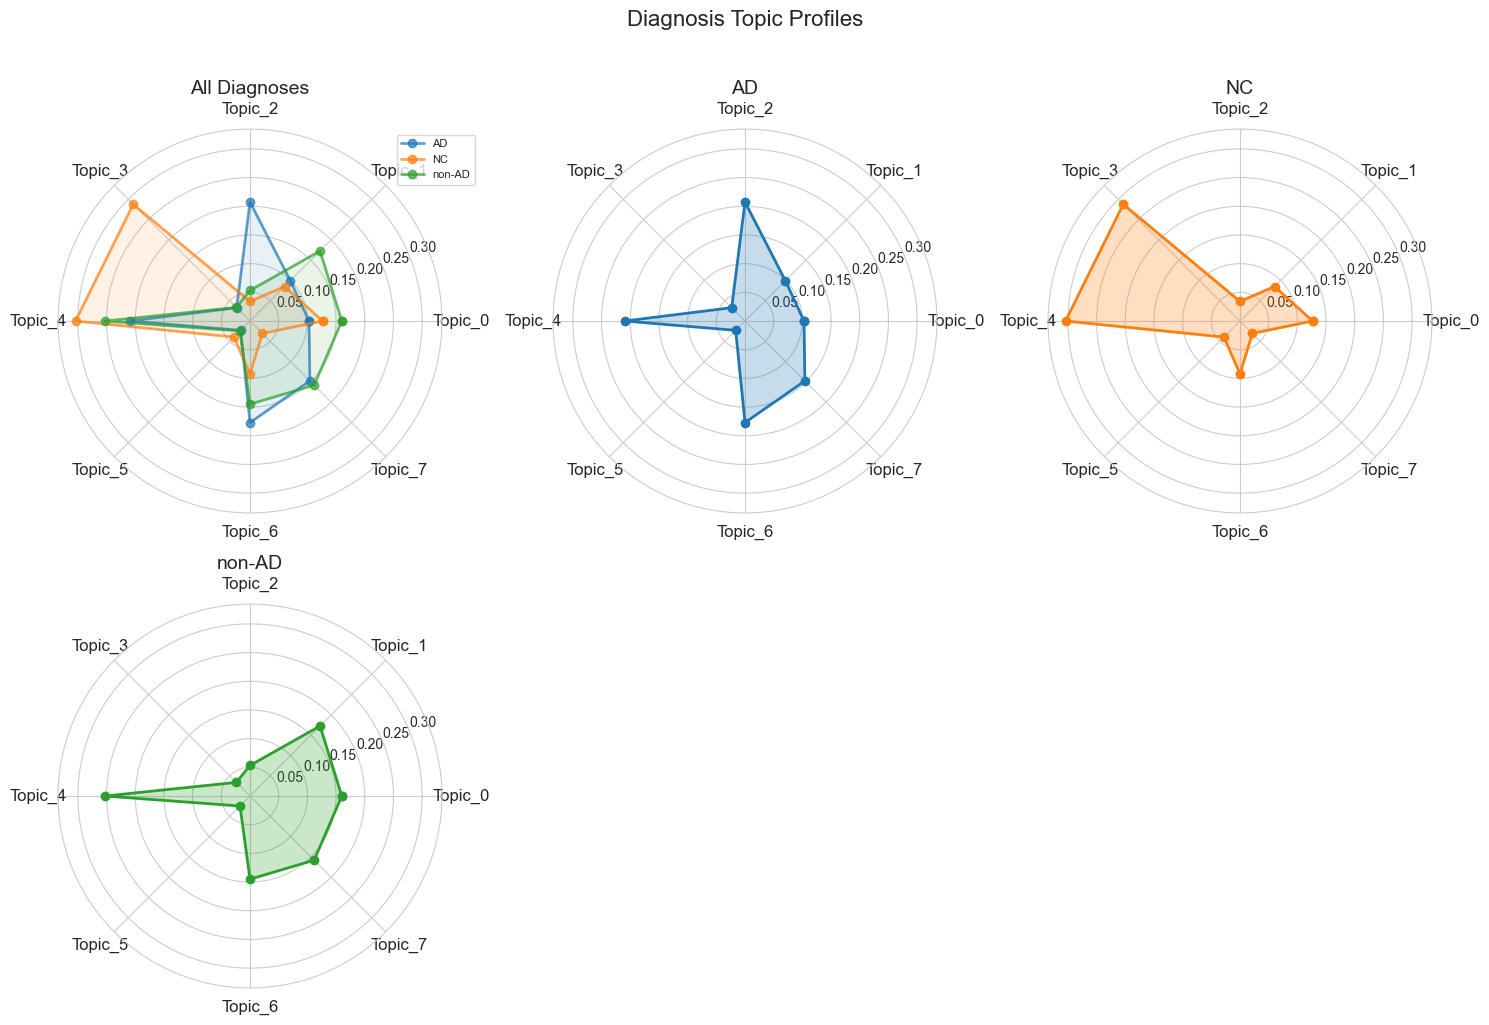

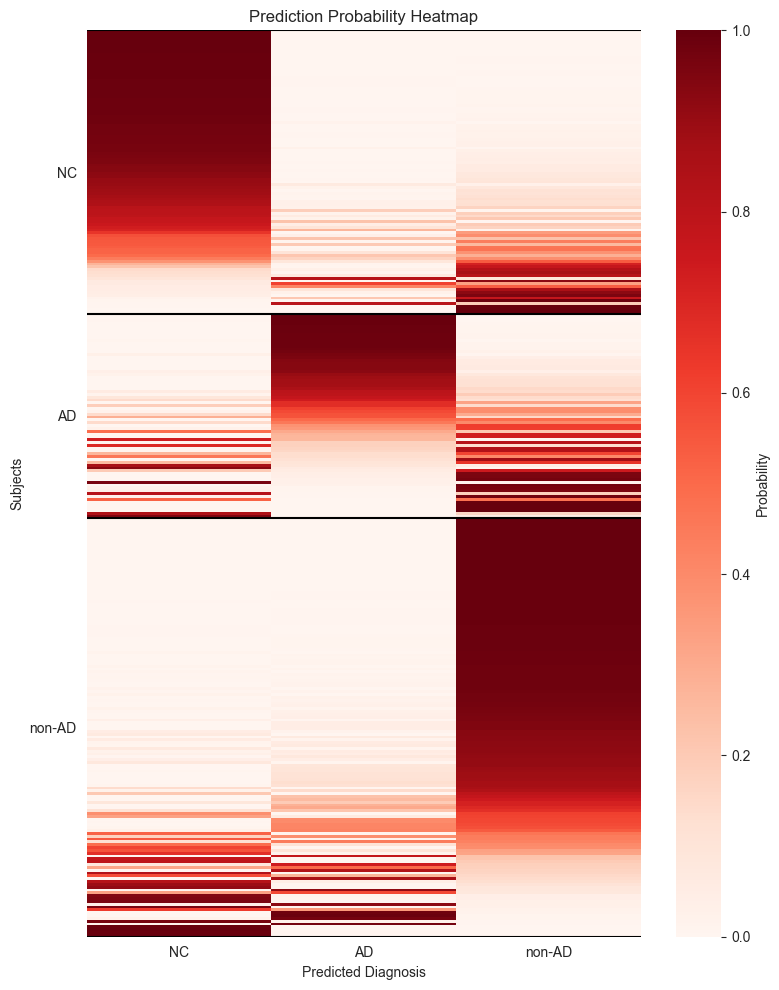

In [7]:
## Internal Visualization
dkt_labels = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/dkt_labels.csv')
rois = dkt_labels.iloc[0].tolist()

visualizer = CopathologyVisualizer(
    output_dir=f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/ad_vs_non_ad/topics_{k}_downsampled'
)
fig_conf_mat = visualizer.plot_confusion_matrix(
    cm=classifier.get_confusion_matrix(),
    class_names=classifier._classes,
    save=False
)

fig_top_regions = visualizer.plot_top_regions_per_topic(
    topic_patterns = lda.get_topic_patterns(),
    region_names=rois,
    save=False
)

radar_plot = visualizer.plot_diagnosis_topic_profiles(
    theta=lda._theta,
    dx_labels = labels,
    save=False
)

probabilities_heatmap = visualizer.plot_probability_heatmap(
    proba_df=classifier.get_cv_results(),
    dx_order = ["NC", "AD", "non-AD"],
    save=False
)

In [ ]:
## Surface Mapping ##
from atlas_vis import DKTAtlas62ROIPlotter
plotter_62  = DKTAtlas62ROIPlotter(
    cmap='Reds',
    clim=(0, 0.1),  
    window_size=(1200, 1000),
    nan_color='lightgray',
    background='white',
    template_key='pial'
)
os.makedirs(f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/ad_vs_non_ad/topics_{k}_downsampled/topicwise',exist_ok=True)

topic_df = pd.DataFrame(
    lda.get_topic_patterns().T,
    index=region_cols,
    columns=[f"Topic_{k}" for k in range(k)]
)

df = topic_df.tail(62).reset_index(drop=True)

print(len(df))
for col in df.columns: ##################
    print(col)
    l_values = df.loc[:30,col].to_list()
    r_values = df.loc[31:,col].to_list()
    print(len(l_values))
    print(len(r_values))
    print(np.min(l_values+r_values))
    print(np.max(l_values+r_values))

    plotter_62(l_values, r_values, save_path=f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/ad_vs_non_ad/topics_{k}_downsampled/topicwise/{col}.png')

In [11]:
# NACC CN included inference ##
nacc_aa_raw = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/nacc/260203_STAGE_PRED_GT_NACC.csv')
nacc_aa_raw = nacc_aa_raw[nacc_aa_raw['DX']!='Unknown']
order = {'low': 0, 'mid': 1, 'high': 2}
gt_num = nacc_aa_raw['TAU/stage_aa_gt'].map(order)
pred_num = nacc_aa_raw['TAU/stage_aa_pred'].map(order)
nacc_aa_raw['TAU/stage_res_subgroup'] = np.select(
    [
        pred_num > gt_num,   # predicted worse than GT
        pred_num == gt_num,  # correct
        pred_num < gt_num    # predicted better than GT
    ],
    [
        'vulnerable',
        'canonical',
        'resilient'
    ],
    default=np.nan
)
region_cols = nacc_aa_raw.loc[:, 'VA/2':'VA/2035'].columns
nacc_aa_cn = nacc_aa_raw[nacc_aa_raw['DX']=='CN']

print(nacc_aa_cn.shape)
print(nacc_aa_raw.shape)

nacc_aa_prep = DataProcessor(
    region_cols=region_cols,
    dx_col = 'DX',
    subject_col='subject_id'
)
nacc_aa_prep.fit_baseline(hc_data=nacc_aa_cn)
nacc_Z = nacc_aa_prep.compute_atrophy_scores(data=nacc_aa_raw)
nacc_theta = lda.transform(nacc_Z)
y_pred = classifier.predict(nacc_theta)
y_proba = classifier.predict_proba(nacc_theta)

nacc_results = pd.DataFrame(nacc_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(nacc_results.shape)
subj_col = nacc_aa_prep.subject_col
if subj_col in nacc_aa_raw.columns:
    nacc_results.insert(0, "SUBJ_ID", nacc_aa_raw[subj_col].values)
    
nacc_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    nacc_results[f"P({dx})"] = y_proba[:,i]

nacc_results = nacc_results.merge(
    nacc_aa_raw[["subject_id", "DX", 'TAU/NEO_SUVR', 'TAU/MTL_SUVR', 'TAU/stage_aa_gt', 'TAU/stage_aa_pred', 'TAU/stage_res_subgroup']],
    left_on="SUBJ_ID",
    right_on="subject_id",
    how="left"
)

nacc_results = nacc_results.drop(columns=["subject_id"])

print(nacc_results['DX'].value_counts())
nacc_results_cn = nacc_results[nacc_results['DX']=='CN']
nacc_results_mci_ad = nacc_results[nacc_results['DX']!='CN']
nacc_results_imci = nacc_results[nacc_results['DX']=='IMCI']
nacc_results_mci = nacc_results[nacc_results['DX']=='MCI']
nacc_results_ad = nacc_results[nacc_results['DX']=='AD']
print(nacc_results.shape)
print(nacc_results['TAU/stage_res_subgroup'].value_counts())

(268, 219)
(400, 219)
(400, 8)
DX
CN      268
MCI      70
AD       52
IMCI     10
Name: count, dtype: int64
(400, 19)
TAU/stage_res_subgroup
canonical     323
resilient      51
vulnerable     26
Name: count, dtype: int64


c:\Users\WooSikKim\anaconda3\envs\data_management\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LatentDirichletAllocation was fitted with feature names
  warnings.warn(


In [15]:
temp = pd.DataFrame(nacc_Z, columns=region_cols)
print(temp.shape)
subj_col = nacc_aa_prep.subject_col
if subj_col in nacc_aa_raw.columns:
    temp.insert(0, "SUBJ_ID", nacc_aa_raw[subj_col].values)
temp.to_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/STAGE_CoPathology/LDA_XGB/z_test_2.csv',index=False)

(400, 95)


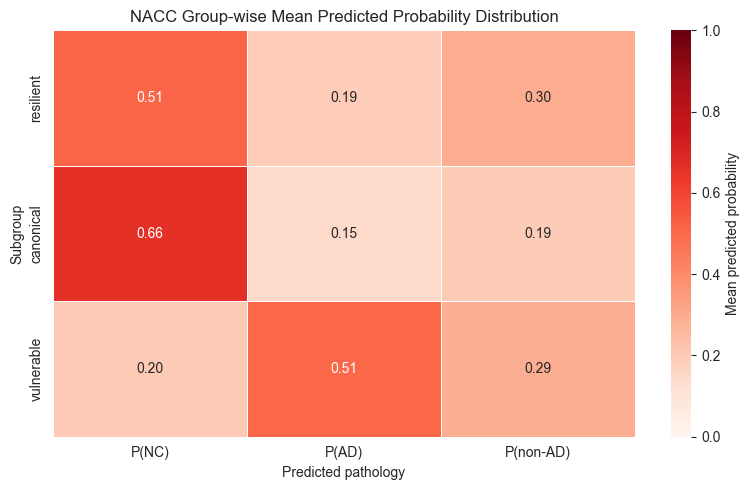

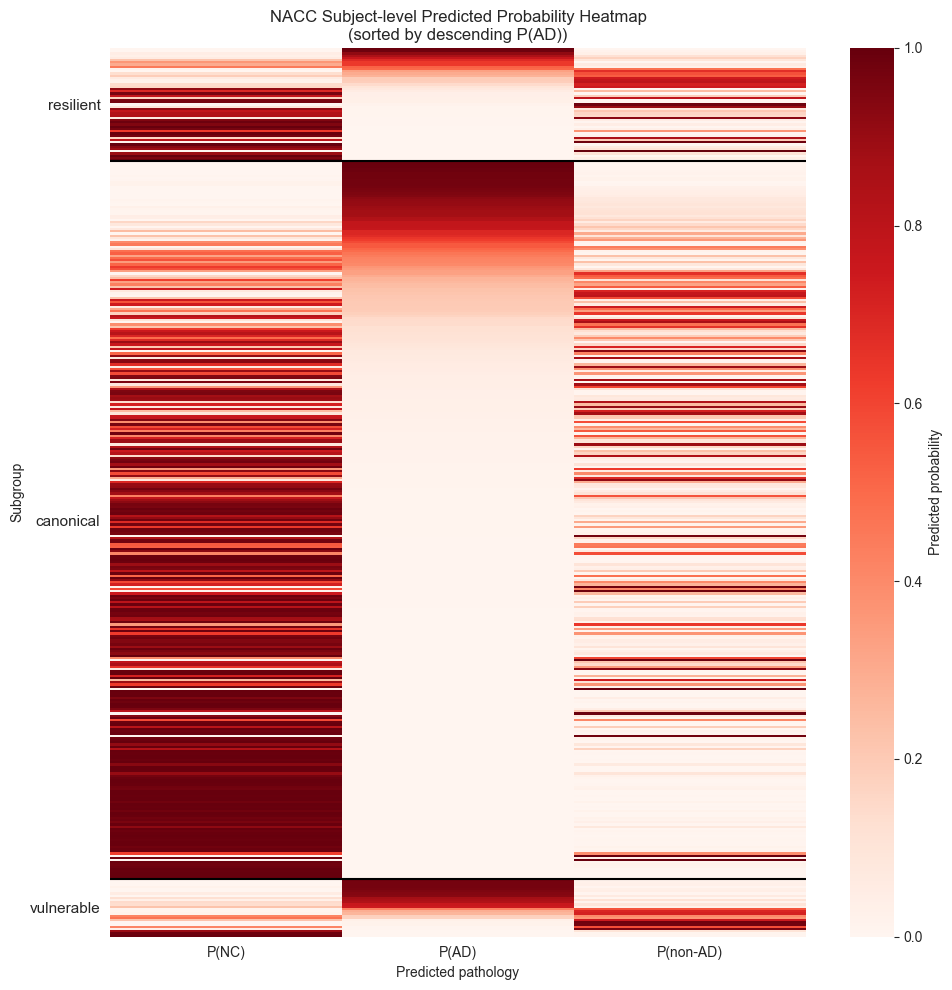

PolarAxes(0.125,0.11;0.227941x0.77) resilient
PolarAxes(0.398529,0.11;0.227941x0.77) canonical
PolarAxes(0.672059,0.11;0.227941x0.77) vulnerable


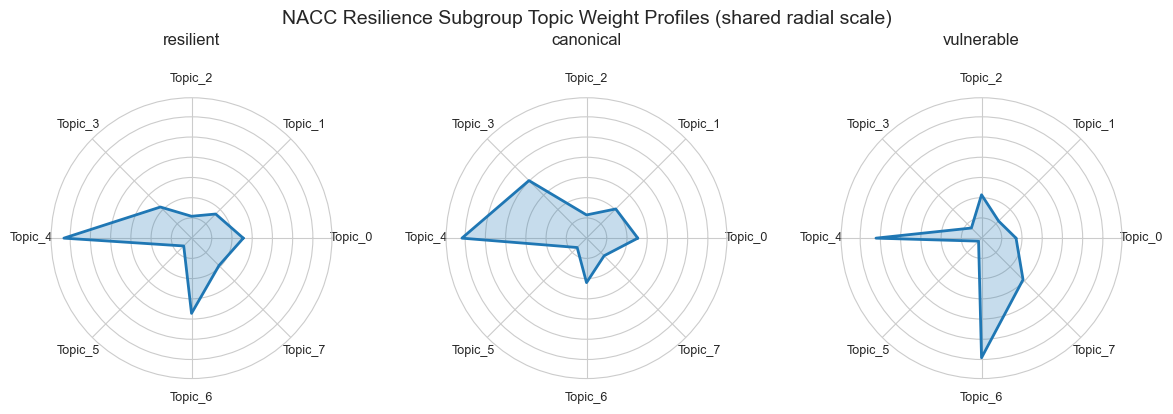

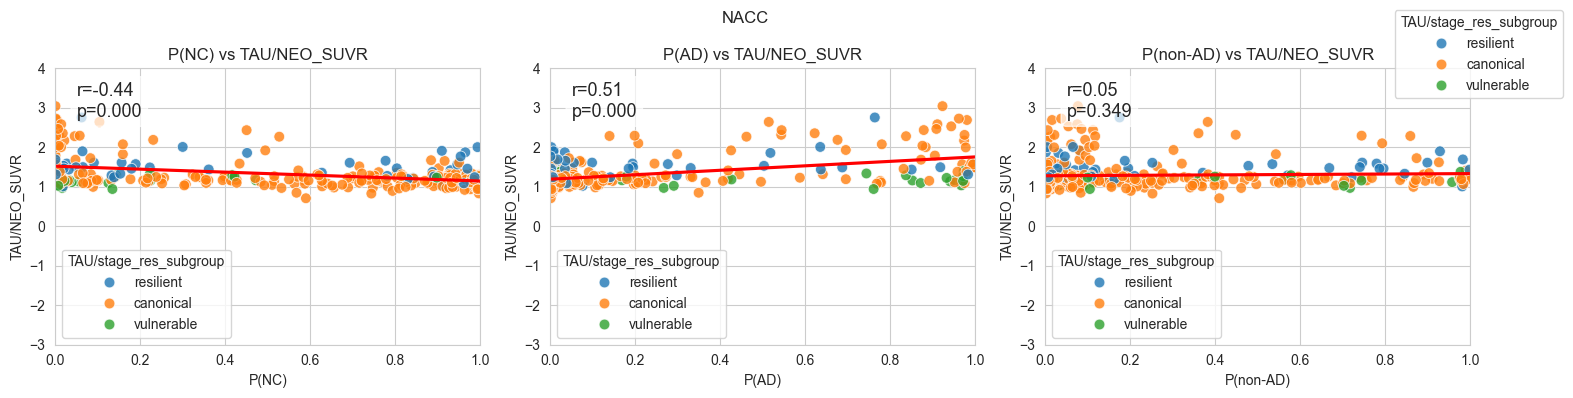

In [10]:
plot_df = nacc_results
# non_ad_cols = ['P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']

prob_cols = ['P(NC)', 'P(AD)', 'P(non-AD)']
group_col = 'TAU/stage_res_subgroup'
group_order = ['resilient', 'canonical', 'vulnerable']

resilient_subgroup_visualization(
    inp_df=plot_df, 
    prob_cols= prob_cols,
    group_col=group_col,
    group_order=group_order,
    cohort='NACC',
    scatter_col='TAU/NEO_SUVR'
)